In [1]:
import tensorflow as tf
import keras
from draw_candle_image import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta.trend
from ta import add_all_ta_features
from ta.utils import dropna
import ta
import ta.momentum
import json
from common_train_utils import *
from functools import partial
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import pathlib
import shutil
import tempfile
import tensorflow_docs.modeling
from model_code import *
import os
from evaluate_old_models import evaluate_btc_model_5

In [2]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [3]:
print(logdir)

C:\Users\ADMIN\AppData\Local\Temp\tmphcpadrx1\tensorboard_logs


In [4]:
dataset_folder = "./dataset/btc_dataset_0_2_3_2012_2024_test_2023_2024_with_trend_type"

In [5]:
config = read_config(dataset_folder)
candle_type_and_directory_save: dict = config["candle_type_and_directory_save"]
previous_days = config["previous_days"]
next_days = config["next_days"]
days_result = config["days_result"]

In [6]:
dataset_test = load_dataset_of_each_type_and_combine(f"{dataset_folder}/test", candle_type_and_directory_save)
total_data_test = len(dataset_test)

folder: bullish_engulfing, 		 total: 19 images
folder: bearish_engulfing, 		 total: 15 images
folder: star_doji, 		 total: 4 images
folder: dragonfly_doji, 		 total: 1 images
folder: gravestone_doji, 		 total: 0 images
folder: morning_star, 		 total: 14 images
folder: evening_star, 		 total: 14 images
folder: hammer, 		 total: 2 images
folder: inverted_hammer, 		 total: 0 images
folder: harami_down, 		 total: 88 images
folder: harami_up, 		 total: 72 images
folder: tweezer_top, 		 total: 14 images
folder: tweezer_bottom, 		 total: 14 images
folder: marubozu, 		 total: 0 images
folder: spin, 		 total: 21 images
folder: next_3_day_up, 		 total: 44 images
folder: next_3_day_down, 		 total: 42 images


In [7]:
dataset_train = load_dataset_of_each_type_and_combine(f"{dataset_folder}/train", candle_type_and_directory_save)
total_data_train = len(dataset_train)

folder: bullish_engulfing, 		 total: 62 images
folder: bearish_engulfing, 		 total: 70 images
folder: star_doji, 		 total: 20 images
folder: dragonfly_doji, 		 total: 6 images
folder: gravestone_doji, 		 total: 11 images
folder: morning_star, 		 total: 57 images
folder: evening_star, 		 total: 54 images
folder: hammer, 		 total: 19 images
folder: inverted_hammer, 		 total: 6 images
folder: harami_down, 		 total: 368 images
folder: harami_up, 		 total: 328 images
folder: tweezer_top, 		 total: 41 images
folder: tweezer_bottom, 		 total: 37 images
folder: marubozu, 		 total: 46 images
folder: spin, 		 total: 88 images
folder: next_3_day_up, 		 total: 235 images
folder: next_3_day_down, 		 total: 168 images


In [8]:
dataset_train

<_ConcatenateDataset element_spec=(TensorSpec(shape=(1,), dtype=tf.int32, name=None), TensorSpec(shape=(287, 287, 3), dtype=tf.float64, name=None), TensorSpec(shape=(6, 4), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [9]:
def get_image_shape(dataset_train):
    for images_train, labels_train, dates_train in dataset_train.take(1):
        break
    image_shape = tuple(images_train.shape)
    return image_shape

def get_image_shape_of_dataset_with_trend_type(dataset_train):
    for trend_type, images_train, labels_train, dates_train in dataset_train.take(1):
        break
    image_shape = tuple(images_train.shape)
    return image_shape

In [10]:
def model_5_with_trend_type(image_shape, days_result):
    trend_type_input = keras.layers.Input(shape=(1,), name="trend_type_input")
    x1 = keras.layers.Dense(8, activation='relu')(trend_type_input)
    
    image_input = keras.layers.Input(shape=image_shape, name="image_input")
    
    x2 = keras.layers.Conv2D(8, (2, 2), activation='relu')(image_input)
    x2 = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x2)
    # x2 = keras.layers.Conv2D(8, (3, 3), activation='relu')(x2)
    # x2 = keras.layers.MaxPooling2D((2, 2))(x2)
    x2 = keras.layers.Flatten()(x2)
    x2 = keras.layers.Dense(64, activation='relu')(x2)
    x2 = keras.layers.Dropout(0.1)(x2)
    
    combined = keras.layers.concatenate([x1, x2])
    
    z = keras.layers.Dense(64, activation='relu')(combined)
    z = keras.layers.Dropout(0.1)(z)
    z = keras.layers.Dense(64, activation='relu')(z)
    
    input_lstm = keras.layers.RepeatVector(days_result)(z)
    lstm = keras.layers.LSTM(128, activation='relu', return_sequences=True)(input_lstm)
    lstm = keras.layers.Dropout(0.1)(lstm)
    output_lstm = keras.layers.TimeDistributed(keras.layers.Dense(2))(lstm)
    
    model = keras.models.Model(inputs=[trend_type_input, image_input], outputs=output_lstm)
    
    return model, "model_5_with_trend_type"

In [11]:
image_shape = get_image_shape_of_dataset_with_trend_type(dataset_train)
model, model_name = model_5_with_trend_type(image_shape, days_result)

In [12]:
batch_size = 64
STEPS_PER_EPOCH = total_data_train // batch_size + 1
name_sub_folder_save_metrics = f"{model_name}_{dataset_folder}"
name_folder_save_metrics = f"sizes/{model_name}_{dataset_folder}"
max_epochs = 100
metric_name = "mean_absolute_error"
metric_object = keras.metrics.MeanAbsoluteError(name=metric_name)
val_loss_metric_to_stop = 1.3
start_learning_rate = 0.01
shuffle_buffer = 300
number_epochs_to_decrease_lr = 30
number_epochs_to_wait = 10

In [13]:
model_name

'model_5_with_trend_type'

In [14]:
STEPS_PER_EPOCH

26

In [15]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 287, 287,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 286, 286,  │        104 │ image_input[0][0] │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 143, 143,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 163592)    │          0 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ trend_type_input    │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │ 10,469,952 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 8)         │         16 │ trend_type_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 72)        │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      4,672 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      4,160 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 3, 64)     │          0 │ dense_3[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 3, 128)    │     98,816 │ repeat_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 3, 128)    │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 3, 2)      │        258 │ dropout_2[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,577,978 (40.35 MB)

 Trainable params: 10,577,978 (40.35 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
(total_data_train, total_data_test)

(1616, 364)

In [17]:
dataset_train_1 = dataset_train.shuffle(shuffle_buffer)
dataset_test_1 = dataset_test.shuffle(shuffle_buffer)

dataset_train_2 = dataset_train_1.batch(batch_size)
dataset_test_2 = dataset_test_1.batch(batch_size)

transform_function = partial(get_open_close_prices_percent_of_last_days_result_for_trend_type_dataset, days_result)
dataset_train_3 = dataset_train_2.map(transform_function)
dataset_test_3 = dataset_test_2.map(transform_function)

In [18]:
for features, labels in dataset_train_3.take(1):
    print(features[0].shape)
    print(features[1].shape)
    print(labels.shape)

(64, 1)
(64, 287, 287, 3)
(64, 3, 2)


In [19]:
(len(dataset_train_3), len(dataset_test_3))

(26, 6)

In [20]:
class StopAtLossValue(keras.callbacks.Callback):
    def __init__(self, target_loss, metric_name):
        super(StopAtLossValue, self).__init__()
        self.target_loss = target_loss
        self.metric_name = metric_name

    def on_epoch_end(self, epoch, logs=None):
        # Lấy giá trị loss từ logs
        current_loss = logs.get(f"val_{self.metric_name}")
        if current_loss is not None and current_loss <= self.target_loss:
            print(f"\nĐạt target loss = {self.target_loss}, dừng training tại epoch {epoch + 1}")
            self.model.stop_training = True

In [21]:
def get_optimizer(start_learning_rate, number_epochs_to_decrease_lr):
    lr_schedule = keras.optimizers.schedules.InverseTimeDecay(
        start_learning_rate,
        decay_steps=STEPS_PER_EPOCH*number_epochs_to_decrease_lr,
        decay_rate=1,
        staircase=False
    )
    
    return keras.optimizers.Adam(lr_schedule)


def get_callbacks(name, metric_name, number_epochs_to_wait):
    return [
        tfdocs.modeling.EpochDots(),
        StopAtLossValue(val_loss_metric_to_stop, metric_name),
        keras.callbacks.EarlyStopping(monitor=f'val_{metric_name}', patience=number_epochs_to_wait),
        keras.callbacks.TensorBoard(logdir/name)
    ]
  
  
model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=get_optimizer(start_learning_rate, number_epochs_to_decrease_lr),
    metrics=[
        metric_object,
    ],
)


In [22]:
is_start_train = input("Start train? (y/n): ").lower()[0] == "y"
if is_start_train:
    history = model.fit(
        dataset_train_3, 
        validation_data=dataset_test_3,
        epochs=max_epochs, 
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=get_callbacks(name_folder_save_metrics, metric_name, number_epochs_to_wait)
    )

Epoch 1/100


d:\code\selenium\.venv\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['trend_type_input', 'image_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 28.5696 - mean_absolute_error: 2.8123
Epoch: 0, loss:18.3787,  mean_absolute_error:2.2833,  val_loss:4.4785,  val_mean_absolute_error:1.3389,  
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 311ms/step - loss: 28.1922 - mean_absolute_error: 2.7927 - val_loss: 4.4785 - val_mean_absolute_error: 1.3389
Epoch 2/100


C:\Users\ADMIN\AppData\Local\Programs\Python\Python39\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0000e+00 - mean_absolute_error: 0.0000e+00 - val_loss: 4.4785 - val_mean_absolute_error: 1.3389
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 308ms/step - loss: 9.4346 - mean_absolute_error: 1.8742 - val_loss: 4.2230 - val_mean_absolute_error: 1.3196
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0000e+00 - mean_absolute_error: 0.0000e+00 - val_loss: 4.2230 - val_mean_absolute_error: 1.3196
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 8.6749 - mean_absolute_error: 1.7758.
Đạt target loss = 1.3, dừng training tại epoch 5
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 308ms/step - loss: 8.7046 - mean_absolute_error: 1.7783 - val_loss: 4.1322 - val_mean_absolute_error: 1.2717


In [23]:
model.evaluate(dataset_test_3, verbose=2)

6/6 - 1s - 158ms/step - loss: 4.1322 - mean_absolute_error: 1.2717


[4.132239818572998, 1.271738886833191]

In [24]:
model_old, loss = evaluate_btc_model_5(candle_type_and_directory_save, batch_size, shuffle_buffer)

folder: bullish_engulfing, 		 total: 19 images
folder: bearish_engulfing, 		 total: 15 images
folder: star_doji, 		 total: 0 images
folder: dragonfly_doji, 		 total: 0 images
folder: gravestone_doji, 		 total: 0 images
folder: morning_star, 		 total: 14 images
folder: evening_star, 		 total: 14 images
folder: hammer, 		 total: 0 images
folder: inverted_hammer, 		 total: 0 images
folder: harami_down, 		 total: 88 images
folder: harami_up, 		 total: 72 images
folder: tweezer_top, 		 total: 14 images
folder: tweezer_bottom, 		 total: 14 images
folder: marubozu, 		 total: 0 images
folder: spin, 		 total: 21 images
folder: next_3_day_up, 		 total: 44 images
folder: next_3_day_down, 		 total: 42 images
6/6 - 1s - 144ms/step - loss: 4.3017 - mean_absolute_error: 1.3910


In [25]:
model_old.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 247107)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │     7,907,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 3, 2)           │           130 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,800,423 (90.79 MB)

 Trainable params: 7,933,474 (30.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 15,866,949 (60.53 MB)

In [26]:
loss

[4.301717281341553, 1.3909714221954346]

In [27]:
def save_dataset(prefix, dataset_test, model_name):
    prefix_of_folder = prefix
    path_save = f"{dataset_folder}/{prefix_of_folder}_of_{model_name}"
    while os.path.exists(path_save):
        print(f"-- {path_save} already exists")
        prefix_of_folder = prefix_of_folder + "_1"
        path_save = f"{dataset_folder}/{prefix_of_folder}_of_{model_name}"
        print(f"-- Change to {path_save}")
    
    print(f"Save to {path_save}")
    tf.data.Dataset.save(dataset_test, path_save)

In [28]:
def save_model(model: keras.Sequential, model_name):
    path_save = f"{dataset_folder}/model_save/{model_name}.keras"
    while os.path.exists(path_save):
        print(f"-- {path_save} already exists")
        model_name = model_name + "_1"
        path_save = f"{dataset_folder}/model_save/{model_name}.keras"
        print(f"-- Change to {path_save}")
    
    print(f"Save to {path_save}")
    model.save(path_save)
    return os.path.basename(path_save).split('.')[0]

In [29]:
model_name_saved = save_model(model, model_name)

-- ./dataset/btc_dataset_0_2_3_2012_2024_test_2023_2024_with_trend_type/model_save/model_5_with_trend_type.keras already exists
-- Change to ./dataset/btc_dataset_0_2_3_2012_2024_test_2023_2024_with_trend_type/model_save/model_5_with_trend_type_1.keras
-- ./dataset/btc_dataset_0_2_3_2012_2024_test_2023_2024_with_trend_type/model_save/model_5_with_trend_type_1.keras already exists
-- Change to ./dataset/btc_dataset_0_2_3_2012_2024_test_2023_2024_with_trend_type/model_save/model_5_with_trend_type_1_1.keras
-- ./dataset/btc_dataset_0_2_3_2012_2024_test_2023_2024_with_trend_type/model_save/model_5_with_trend_type_1_1.keras already exists
-- Change to ./dataset/btc_dataset_0_2_3_2012_2024_test_2023_2024_with_trend_type/model_save/model_5_with_trend_type_1_1_1.keras
-- ./dataset/btc_dataset_0_2_3_2012_2024_test_2023_2024_with_trend_type/model_save/model_5_with_trend_type_1_1_1.keras already exists
-- Change to ./dataset/btc_dataset_0_2_3_2012_2024_test_2023_2024_with_trend_type/model_save/mo

In [30]:
size_histories = {}

In [31]:
size_histories[name_sub_folder_save_metrics] = history 

(0.0, 2.0)

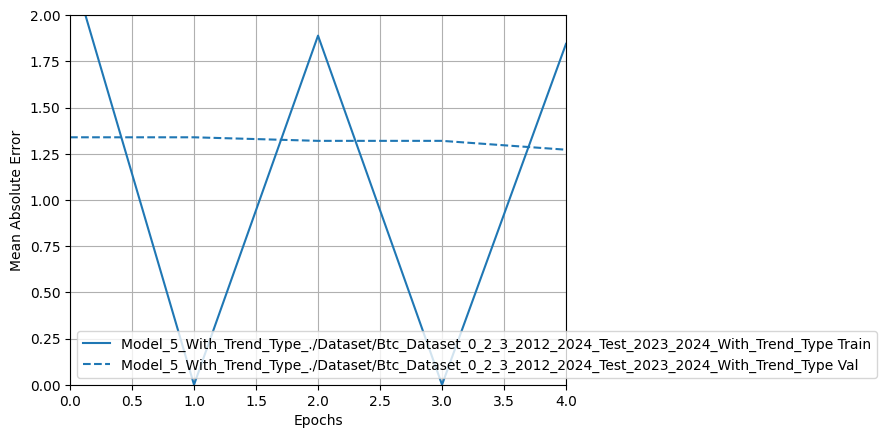

In [32]:
plotter = tfdocs.plots.HistoryPlotter(metric=metric_name, smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0,2])

In [33]:
# train_dataset = tf.data.Dataset.load(f'{dataset_folder}/train/next_3_day_up')
# test_dataset = tf.data.Dataset.load(f'{dataset_folder}/test/next_3_day_up')
# for x_train, y_train, date_train in train_dataset.take(2):
#     pass
# for x_test, y_test, date_test in test_dataset.take(2):
#     pass
# plt.imshow(x_train)
# y_train
# plt.imshow(x_test)
# y_test

In [34]:
model_name_saved

'model_5_with_trend_type_1_1_1_1_1'

In [35]:
dataset_folder

'./dataset/btc_dataset_0_2_3_2012_2024_test_2023_2024_with_trend_type'